In [2]:
import pandas as pd
import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller


In [ ]:
fear = pd.read_csv("../dataset/fear_index.csv")
fear["date"] = pd.to_datetime(fear["date"])
fear = fear.sort_values("date")

fear.head()


,date,fear_simple
0,2016-01-01,0.718912
1,2016-01-04,1.268558
2,2016-01-05,1.249420
3,2016-01-06,1.348763
4,2016-01-07,1.491106


In [ ]:
fx = pd.read_csv("../dataset/DEXKOUS-old.csv")
fx["observation_date"] = pd.to_datetime(fx["observation_date"])
fx = fx.sort_values("observation_date")

fx.head()


,observation_date,DEXKOUS
0,2000-01-03,1128.0
1,2000-01-04,1122.5
2,2000-01-05,1135.0
3,2000-01-06,1146.5
4,2000-01-07,1138.0


In [5]:
df = pd.merge(
    fear,
    fx,
    left_on="date",
    right_on="observation_date",
    how="inner"
)

df = df.set_index("date")
df = df[["fear_simple", "DEXKOUS"]].dropna()

df = df.loc["2016-01-01":"2025-12-30"]

df.head()


,fear_simple,DEXKOUS
date,,
2016-01-04,1.268558,1191.46
2016-01-05,1.249420,1190.43
2016-01-06,1.348763,1200.16
2016-01-07,1.491106,1193.05
2016-01-08,1.451058,1206.97


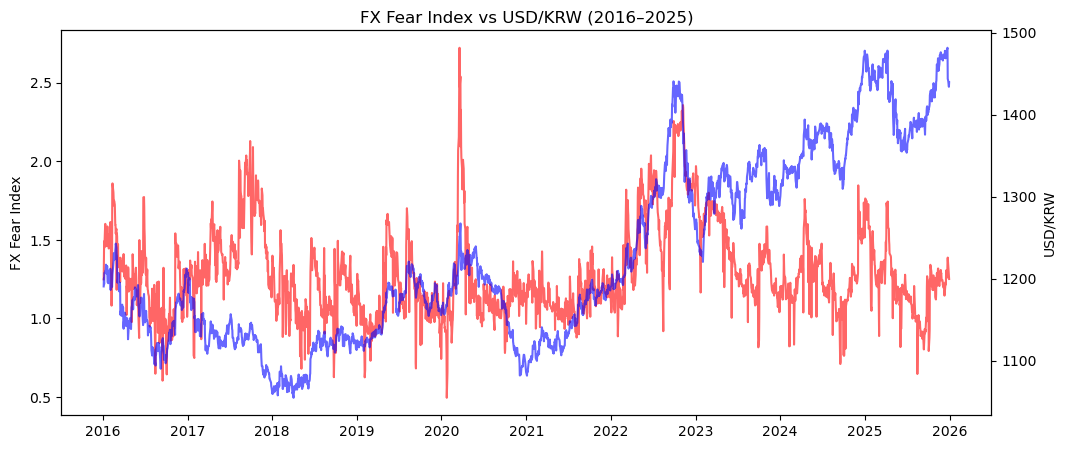

In [8]:
fig, ax1 = plt.subplots()

ax1.plot(df.index, df["fear_simple"], color="red", alpha=0.6, label="FX Fear Index")
ax1.set_ylabel("FX Fear Index")

ax2 = ax1.twinx()
ax2.plot(df.index, df["DEXKOUS"], color="blue", alpha=0.6, label="USD/KRW")
ax2.set_ylabel("USD/KRW")

ax1.set_title("FX Fear Index vs USD/KRW (2016–2025)")
plt.show()


Granger Casuality 분석 

In [6]:
# -----------------------------
# 1) Make stationary series
#    - FX: log-diff (returns)
#    - Fear: option (level or diff)
# -----------------------------
df["fx_ret"] = np.log(df["DEXKOUS"]).diff()

USE_FEAR_DIFF = False  # <- 필요하면 True로 바꿔서 fear도 차분해서 테스트
if USE_FEAR_DIFF:
    df["fear_used"] = df["fear_simple"].diff()
else:
    df["fear_used"] = df["fear_simple"]

data = df[["fx_ret", "fear_used"]].dropna().copy()
data.columns = ["fx_ret", "fear"]


In [7]:
# -----------------------------
# 2) Quick stationarity check (optional)
# -----------------------------
def adf_pvalue(s: pd.Series) -> float:
    s = s.dropna()
    if len(s) < 30:
        return np.nan
    return adfuller(s, autolag="AIC")[1]

print("[ADF p-values]")
print("fx_ret:", adf_pvalue(data["fx_ret"]))
print("fear  :", adf_pvalue(data["fear"]))


[ADF p-values]
fx_ret: 0.0
fear  : 5.478656378912241e-07


In [8]:
# -----------------------------
# 3) Choose lag (VAR order selection)
# -----------------------------
maxlags = 10  # 일별 데이터면 5~20도 가능. 표본/안정성 보고 조절.
var = VAR(data)
order = var.select_order(maxlags=maxlags)

print("\n[VAR lag order selection]")
print(order.summary())

# 보수적으로 BIC 우선, 없으면 AIC
best_lag = int(order.selected_orders.get("bic") or order.selected_orders.get("aic") or 1)
best_lag = max(1, best_lag)
print("chosen_lag:", best_lag)


[VAR lag order selection]
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -12.89      -12.89   2.513e-06      -12.89
1       -14.76      -14.74   3.907e-07      -14.75
2       -14.81      -14.79   3.688e-07      -14.80
3       -14.83      -14.80   3.625e-07      -14.82
4       -14.84     -14.80*   3.586e-07      -14.83
5       -14.85      -14.80   3.565e-07     -14.83*
6      -14.85*      -14.79  3.554e-07*      -14.83
7       -14.85      -14.78   3.558e-07      -14.82
8       -14.85      -14.77   3.562e-07      -14.82
9       -14.85      -14.76   3.561e-07      -14.82
10      -14.85      -14.75   3.568e-07      -14.81
--------------------------------------------------
chosen_lag: 4


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [9]:
# -----------------------------
# 4) Granger causality tests
#    statsmodels expects columns order [Y, X]
# -----------------------------
def granger_pvals(df_yx: pd.DataFrame, maxlag: int):
    """
    df_yx: columns must be [Y, X]
    returns dict: {lag: pvalue} using ssr_ftest
    """
    res = grangercausalitytests(df_yx, maxlag=maxlag, verbose=False)
    return {lag: res[lag][0]["ssr_ftest"][1] for lag in res.keys()}

# (A) fear -> fx_ret
p_fear_to_fx = granger_pvals(data[["fx_ret", "fear"]], maxlag=best_lag)

# (B) fx_ret -> fear
p_fx_to_fear = granger_pvals(data[["fear", "fx_ret"]], maxlag=best_lag)

print("\n[Granger p-values by lag] (ssr_ftest)")
print("fear -> fx_ret:", p_fear_to_fx)
print("fx_ret -> fear:", p_fx_to_fear)

# Best (min) p-value lag
bestA = min(p_fear_to_fx, key=p_fear_to_fx.get)
bestB = min(p_fx_to_fear, key=p_fx_to_fear.get)

print("\n[Summary]")
print(f"fear -> fx_ret: min p={p_fear_to_fx[bestA]:.4g} at lag={bestA}")
print(f"fx_ret -> fear: min p={p_fx_to_fear[bestB]:.4g} at lag={bestB}")

alpha = 0.05
print("\n[Decision @ alpha=0.05]")
print("fear Granger-causes fx_ret?" , any(p < alpha for p in p_fear_to_fx.values()))
print("fx_ret Granger-causes fear?" , any(p < alpha for p in p_fx_to_fear.values()))


[Granger p-values by lag] (ssr_ftest)
fear -> fx_ret: {1: 0.015070596988962032, 2: 0.030187223015228262, 3: 0.05961340044022901, 4: 0.02188608322483639}
fx_ret -> fear: {1: 0.003489433851038085, 2: 7.85042574807275e-05, 3: 5.997303098057108e-06, 4: 2.0557403701566135e-08}

[Summary]
fear -> fx_ret: min p=0.01507 at lag=1
fx_ret -> fear: min p=2.056e-08 at lag=4

[Decision @ alpha=0.05]
fear Granger-causes fx_ret? True
fx_ret Granger-causes fear? True


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


결과 해석

fear -> fx_ret에서 p-value < 0.05가 있으면
→ “공탐지수가 환율 변동의 선행 정보성을 가진다(Granger)”

반대로 fx_ret -> fear가 유의하면
→ “환율 변동이 공탐지수에도 반영된다(피드백 가능)”

둘 다 유의하면 양방향, 둘 다 아니면 “선행성 뚜렷하지 않음”

시각화

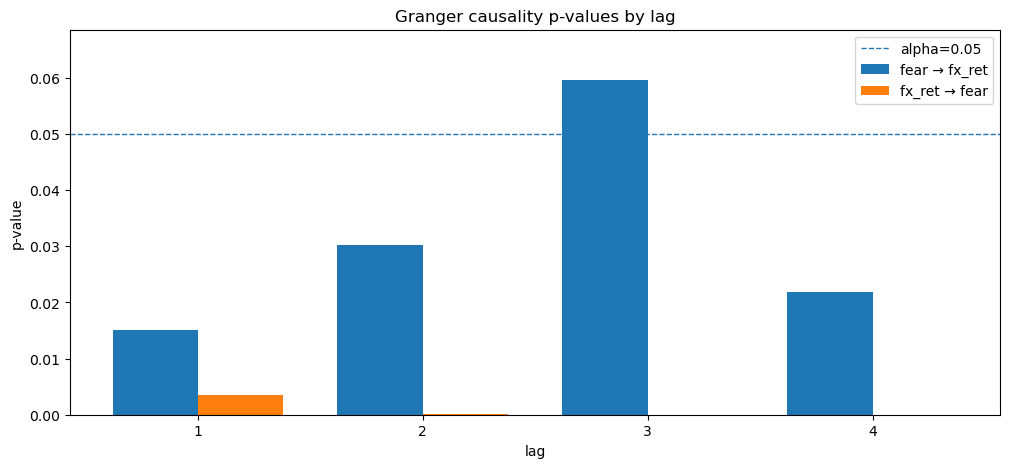

In [10]:
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.05

lags = sorted(p_fear_to_fx.keys())
p1 = [p_fear_to_fx[l] for l in lags]   # fear -> fx
p2 = [p_fx_to_fear[l] for l in lags]   # fx -> fear

x = np.arange(len(lags))
width = 0.38

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, p1, width=width, label="fear → fx_ret")
plt.bar(x + width/2, p2, width=width, label="fx_ret → fear")

plt.axhline(alpha, linestyle="--", linewidth=1, label="alpha=0.05")
plt.xticks(x, lags)
plt.ylim(0, min(1.0, max(p1 + p2) * 1.15))
plt.title("Granger causality p-values by lag")
plt.xlabel("lag")
plt.ylabel("p-value")
plt.legend()
plt.show()


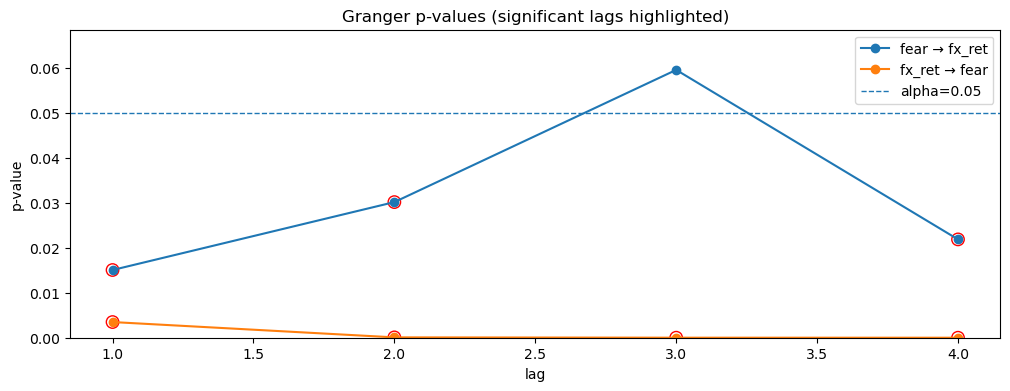

Significant lags (fear → fx_ret): [1, 2, 4]
Significant lags (fx_ret → fear): [1, 2, 3, 4]


In [11]:
plt.figure(figsize=(12, 4))

plt.plot(lags, p1, marker="o", label="fear → fx_ret")
plt.plot(lags, p2, marker="o", label="fx_ret → fear")
plt.axhline(alpha, linestyle="--", linewidth=1, label="alpha=0.05")

# 유의한 lag는 강조(빨간 테두리)
sig_lags_1 = [l for l in lags if p_fear_to_fx[l] < alpha]
sig_lags_2 = [l for l in lags if p_fx_to_fear[l] < alpha]

plt.scatter(sig_lags_1, [p_fear_to_fx[l] for l in sig_lags_1], s=80, facecolors="none", edgecolors="red")
plt.scatter(sig_lags_2, [p_fx_to_fear[l] for l in sig_lags_2], s=80, facecolors="none", edgecolors="red")

plt.title("Granger p-values (significant lags highlighted)")
plt.xlabel("lag")
plt.ylabel("p-value")
plt.ylim(0, min(1.0, max(p1 + p2) * 1.15))
plt.legend()
plt.show()

print("Significant lags (fear → fx_ret):", sig_lags_1)
print("Significant lags (fx_ret → fear):", sig_lags_2)


In [12]:
bestA = min(p_fear_to_fx, key=p_fear_to_fx.get)
bestB = min(p_fx_to_fear, key=p_fx_to_fear.get)

print(f"fear → fx_ret : min p = {p_fear_to_fx[bestA]:.4g} at lag={bestA}")
print(f"fx_ret → fear : min p = {p_fx_to_fear[bestB]:.4g} at lag={bestB}")
print(f"(chosen_lag used) = {best_lag}")


fear → fx_ret : min p = 0.01507 at lag=1
fx_ret → fear : min p = 2.056e-08 at lag=4
(chosen_lag used) = 4
